In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
himanshunayal_intent_recognition_dataset_path = kagglehub.dataset_download('himanshunayal/intent-recognition-dataset')

print('Data source import complete.')


Data source import complete.


# Import Toolkits

In [2]:
!pip install datasets

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import re
plt.style.use("ggplot")

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.preprocessing import LabelEncoder

from transformers import DistilBertTokenizer , DistilBertForSequenceClassification , Trainer , TrainingArguments
from datasets import Dataset
import torch

In [4]:
import nltk
nltk.download("stopwords")
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Read in Data

In [5]:
df = pd.read_csv(f"{himanshunayal_intent_recognition_dataset_path}/train.csv")
df.sample(10)

,text,intent
11981,play top rosanne cash,PlayMusic
8,find fish story,SearchScreeningEvent
6782,add track by klute to winifred s de camino a c...,AddToPlaylist
1144,book reservations at a restaurant in jersey fo...,BookRestaurant
2201,please search for sealed with a kiss movie,SearchCreativeWork
2825,what is the movie schedule of animated movies ...,SearchScreeningEvent
11595,play some robbie merrill,PlayMusic
10461,what movie times,SearchScreeningEvent
8325,find half a truth,SearchScreeningEvent
11987,play nightbirds on nantucket soundtrack,SearchCreativeWork


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13084 entries, 0 to 13083
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    13084 non-null  object
 1   intent  13084 non-null  object
dtypes: object(2)
memory usage: 204.6+ KB


In [7]:
df = df.sample(n = 6000 , random_state = 42).reset_index(drop = True)
print(df.shape)
df.head()

(6000, 2)


,text,intent
0,rate this series chronicle 0 points,RateBook
1,i want to hear the album suites & sweets,PlayMusic
2,book me a table for five at the top-rated moro...,BookRestaurant
3,what s the weather in springside nature reserv...,GetWeather
4,book a table in hallwood for one for supper,BookRestaurant


# Data Pre-processing

In [8]:
port_stem = PorterStemmer()

In [9]:
def clean_statement(text):
  text = text.lower()
  tokens = word_tokenize(text)
  words = [port_stem.stem(word) for word in tokens if word not in stopwords.words('english')]
  statement = " ".join(words)

  return statement

In [10]:
df['text'] = df['text'].apply(clean_statement)

In [11]:
df.head()

,text,intent
0,rate seri chronicl 0 point,RateBook
1,want hear album suit & sweet,PlayMusic
2,book tabl five top-rat morocco restaur,BookRestaurant
3,weather springsid natur reserv four pm,GetWeather
4,book tabl hallwood one supper,BookRestaurant


In [12]:
print(df['intent'].nunique())
df['intent'].value_counts(normalize = True)

7


,proportion
intent,
SearchScreeningEvent,0.146500
GetWeather,0.145000
PlayMusic,0.144667
RateBook,0.144500
BookRestaurant,0.144000
SearchCreativeWork,0.140000
AddToPlaylist,0.135333


In [13]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['intent'])
df.head()

,text,intent,label
0,rate seri chronicl 0 point,RateBook,4
1,want hear album suit & sweet,PlayMusic,3
2,book tabl five top-rat morocco restaur,BookRestaurant,1
3,weather springsid natur reserv four pm,GetWeather,2
4,book tabl hallwood one supper,BookRestaurant,1


# Data Split

In [14]:
X = df['text']
y = df['label']

In [15]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , random_state = 42)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4800,)
X_test shape: (1200,)
y_train shape: (4800,)
y_test shape: (1200,)


# Tokenization

In [16]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [17]:
train_encodings = tokenizer(list(X_train), truncation=True, padding=True , max_length = 200)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length = 200)

In [18]:
#convert to dataset format
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'],'attention_mask': train_encodings['attention_mask'],'labels': y_train.tolist()})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'],'attention_mask': test_encodings['attention_mask'],'labels': y_test.tolist()})

In [19]:
train_dataset[0]

{'input_ids': [101,
  9491,
  4078,
  2121,
  2615,
  1014,
  2732,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'labels': 4}

In [20]:
len(label_encoder.classes_)

7

In [21]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased" , num_labels = len(label_encoder.classes_))
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10
)

trainer = Trainer(
    model = model,
    args= training_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset
)
trainer.train()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: abdelrhmanessam829 (abdelrhmanessam829-a-student) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,1.943000
20,1.963200
30,1.943500
40,1.950800
50,1.931900
60,1.921700
70,1.920300
80,1.870300
90,1.771900
100,1.654800


TrainOutput(global_step=1500, training_loss=0.23513974008585015, metrics={'train_runtime': 5767.2011, 'train_samples_per_second': 4.161, 'train_steps_per_second': 0.26, 'total_flos': 217348704720000.0, 'train_loss': 0.23513974008585015, 'epoch': 5.0})

# Evaluation

                      precision    recall  f1-score   support

       AddToPlaylist       0.99      0.98      0.99       166
      BookRestaurant       0.99      1.00      1.00       153
          GetWeather       1.00      0.99      1.00       146
           PlayMusic       0.95      0.97      0.96       179
            RateBook       1.00      1.00      1.00       169
  SearchCreativeWork       0.94      0.94      0.94       197
SearchScreeningEvent       0.98      0.96      0.97       190

            accuracy                           0.98      1200
           macro avg       0.98      0.98      0.98      1200
        weighted avg       0.98      0.98      0.98      1200



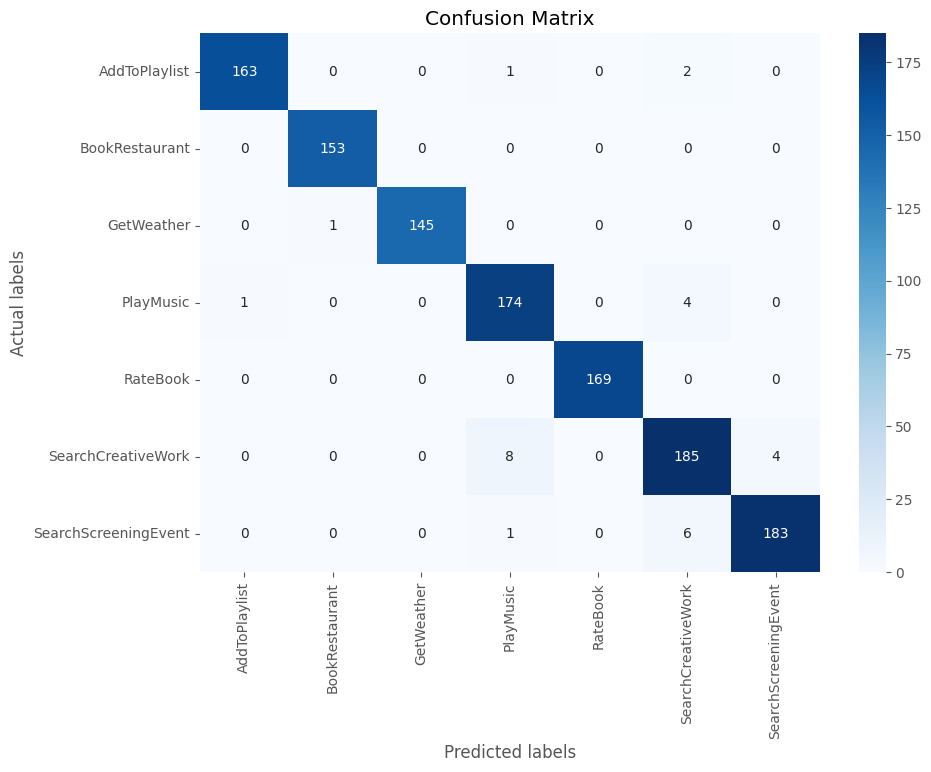

In [22]:
predictions , labels , _ = trainer.predict(test_dataset)

#convert predictions to class labels
predicted_labels = np.argmax(predictions , axis = 1)

#Classification Report
print(classification_report(y_test , predicted_labels , target_names= label_encoder.classes_))

#Confusion Matrix
cm = confusion_matrix(y_test , predicted_labels)
plt.figure(figsize = (10,7))
sns.heatmap(cm , annot = True , fmt = 'd' , cmap = 'Blues' , xticklabels = label_encoder.classes_ , yticklabels = label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.title("Confusion Matrix")
plt.show();

# Save & Load Model

In [24]:
model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")

('./fine_tuned_model/tokenizer_config.json',
 './fine_tuned_model/special_tokens_map.json',
 './fine_tuned_model/vocab.txt',
 './fine_tuned_model/added_tokens.json')

# Inference: Prediction System

In [25]:
model = DistilBertForSequenceClassification.from_pretrained("./fine_tuned_model")
tokenizer = DistilBertTokenizer.from_pretrained("./fine_tuned_model")

In [26]:
def predict(text , model , tokenizer , max_length = 200):
  #lower case and remove stopwords
  text = clean_statement(text)

  #tokenize
  inputs = tokenizer(text , return_tensors = 'pt' , truncation = True , padding = "max_length" , max_length = max_length)

  #predict
  with torch.no_grad():
    outputs = model(**inputs)
    label_to_idogits = outputs.logits

  predicted_label = torch.argmax(label_to_idogits , dim=1).item()
  predicted_class = label_encoder.inverse_transform([predicted_label])[0]

  return predicted_class

text = "play some fun music"
predict(text , model , tokenizer)

'PlayMusic'